# Heart Disease Risk Assessment using Bayesian Networks

### Authors: Matteo Fasulo, Luca Tedeschini, Antonio Gravina, Luca babboni

### Course: Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3) - Alma Mater Studiorum Università di Bologna

### Overview

**Cardiovascular diseases** (CVDs) are the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 32% of all deaths worldwide. Four out of 5 CVD deaths are due to heart attacks and strokes, and one third of these deaths occur prematurely in people under 70 years of age [[1]](#1). 

The main risk factors for **heart disease** are unhealthy diet, physical inactivity, tobacco use and harmful use of alcohol. The effects may include raised blood pressure, raised blood glucose, raised blood lipids, and overweight and obesity [[1]](#1). Since the 1930s, research has identified diverse **CVD risk factors** [[2]](#2). Notably, the World Health Organization categorizes factors as modifiable (influenced by lifestyle) and non-modifiable [[3]](#3). Interestingly, modifiable factors can be significantly impacted by individual choices and interventions. 

In this notebook, we will use a **Bayesian Network** to assess the **risk of heart disease** in a patient based on these risk factors. We will face the modelling of **causal relations** between the risk factors and the disease, and we will use the network to make **predictions** about the risk of heart disease in a patient. The aim is to learn a model which **given** the risk factors of a patient as input (**evidence**), can predict the probability of the patient having heart disease. The causal relations between the risk factors and the disease will be both learned from data and from **domain knowledge** found in the **literature** and in **medical guidelines**.

The work was inspired by a paper [[4]](#4) in which the authors used a Bayesian Network to assess the risk of heart disease in a patient. Their work guided us in the choice of the risk factors and in the structure of the network. However, we will use a different dataset and we will use a different approach to learn the parameters of the network.

# Libraries

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import *
from pgmpy.inference import VariableElimination
from pgmpy.metrics import *
from pgmpy.metrics.bn_inference import *
from pgmpy.readwrite import XMLBIFWriter

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# Preprocessing

The original dataset 

In [2]:
df = pd.read_csv(f'data{os.sep}heart.csv')
df = df[~(df['Cholesterol'] == 0) & ~(df['RestingBP'] == 0)]

In [3]:
df['Oldpeak'].describe()

count    746.000000
mean       0.901609
std        1.072861
min       -0.100000
25%        0.000000
50%        0.500000
75%        1.500000
max        6.200000
Name: Oldpeak, dtype: float64

In [4]:
df = df[~(df['Cholesterol'] == 0) & ~(df['RestingBP'] == 0)]

df['ExerciseAngina'] = df['ExerciseAngina'].apply(
    lambda x: False if x == 'N' else True)
df['HeartDisease'] = df['HeartDisease'].apply(
    lambda x: False if x == 0 else True)

df['FastingBS'] = df['FastingBS'].apply(lambda x: False if x == 0 else True)
df["Age"] = pd.cut(x=df["Age"], bins=[20, 30, 40, 50, 60, 70, 80], labels=[
                   "20-30", "30-40", "40-50", "50-60", "60-70", "70-80"])
df["RestingBP"] = pd.cut(x=df["RestingBP"], bins=[90, 120, 140, np.Inf], labels=[
                         "normal", "high", "very-high"])
df["Cholesterol"] = pd.cut(x=df["Cholesterol"], bins=[
                           0, 200, 240, np.Inf], labels=["optimal", "borderline", "high"])
df["MaxHR"] = pd.qcut(x=df["MaxHR"], q=4, labels=["low", "medium", "high", "very-high"])
df["Oldpeak"] = pd.cut(x=df["Oldpeak"], bins=[-np.Inf, 0.5, 1, 2, np.Inf], labels=[
                       "<=0.5", "0-5-1", "1-2", "2+"])

In [5]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,30-40,M,ATA,high,high,False,Normal,very-high,False,<=0.5,Up,False
1,40-50,F,NAP,very-high,optimal,False,Normal,high,False,0-5-1,Flat,True
2,30-40,M,ATA,high,high,False,ST,low,False,<=0.5,Up,False
3,40-50,F,ASY,high,borderline,False,Normal,low,True,1-2,Flat,True
4,50-60,M,NAP,very-high,optimal,False,Normal,low,False,<=0.5,Up,False


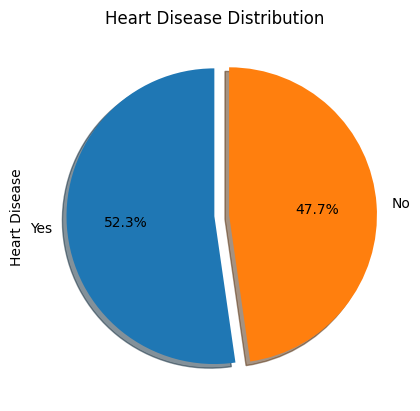

In [6]:
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90, explode=[0, 0.1], shadow=True, labels=["Yes", "No"], label="Heart Disease", title="Heart Disease Distribution")
plt.show()

In [7]:
target_variable = "HeartDisease"
X, y = df.drop(columns=target_variable), df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Bayesian Network from Hill Climbing unconstrained

In [8]:
estimated_model = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore')

  0%|          | 0/1000000 [00:00<?, ?it/s]

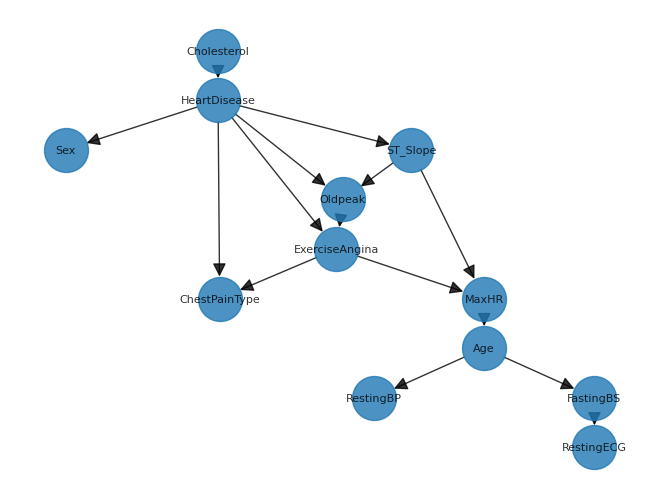

In [9]:
pos = nx.nx_agraph.graphviz_layout(estimated_model, prog="dot")
nx.draw(estimated_model, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)

Ok, good but we want to express some edges and remove other with no causal meaning. We proceed to remove:
- HeartDisease -> Cholesterol
- Oldpeak -> HeartDisease
- ST_Slope -> HeartDisease
- ST_Slope -> MaxHR
- Nothing affects Age
- Nothing affects Sex

# Constrained

In [10]:
black_list = [(target_variable, 'Cholesterol'),
              ('Oldpeak', target_variable),
              ('ST_Slope', target_variable),
              ('ST_Slope', 'MaxHR'),
              ('ExerciseAngina', 'Cholesterol'),
              ('ST_Slope', 'Oldpeak'),
              ('ExerciseAngina', 'RestingECG'),
              ('ExerciseAngina', 'ChestPainType')] + [(x, 'Sex')for x in df.columns] + [(x, 'Age') for x in df.columns]

In [16]:
estimated_model = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore', black_list=black_list)

  0%|          | 0/1000000 [00:00<?, ?it/s]

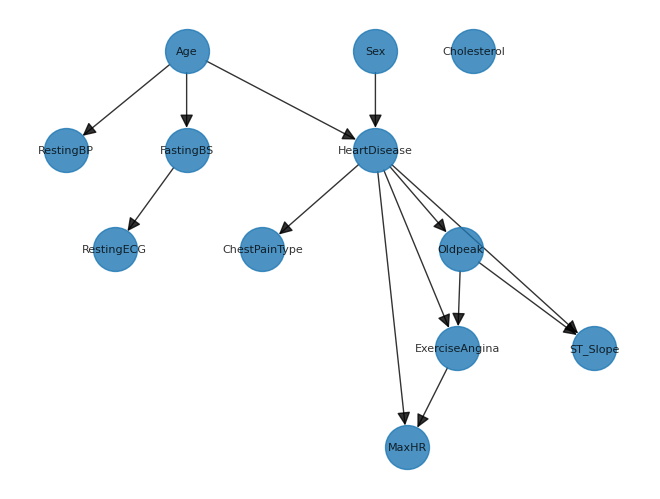

In [17]:
pos = nx.nx_agraph.graphviz_layout(estimated_model, prog="dot")
nx.draw(estimated_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

In [18]:
estimated_model.add_edge('Sex', 'Cholesterol')
estimated_model.add_edge('Cholesterol', target_variable)
estimated_model.add_edge('Oldpeak', 'ST_Slope')
estimated_model.add_edge('RestingECG', target_variable)
estimated_model.add_edge('RestingBP', target_variable)
estimated_model.add_edge('Cholesterol', 'RestingBP')
estimated_model.add_edge('FastingBS', target_variable)
estimated_model.add_edge('Age', 'Cholesterol')

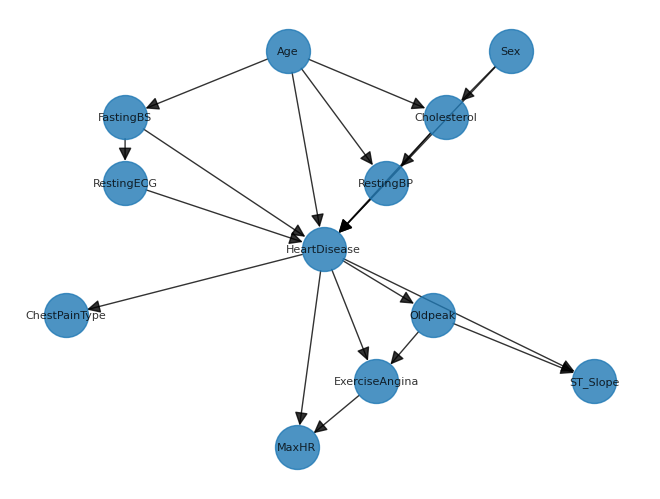

In [19]:
pos = nx.nx_agraph.graphviz_layout(estimated_model, prog="dot")
nx.draw(estimated_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

In [20]:
model = BayesianNetwork(estimated_model.edges())

In [21]:
model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
model.get_cpds()
assert model.check_model()

In [50]:
if not os.path.isdir('model'):
    os.mkdir('model')
model.save(f'model{os.sep}heart_disease_model.bif')
writer = XMLBIFWriter(model)
writer.write_xmlbif(f'model{os.sep}heart_disease_model.xml')

In [22]:
y_pred = model.predict(X_test)
y_pred.head()

  0%|          | 0/147 [00:00<?, ?it/s]

,HeartDisease
0,False
1,False
2,False
3,False
4,True


In [23]:
fbeta_score(y_test, y_pred[target_variable], beta=2)

0.7603092783505154

In [17]:
accuracy_score(y_test, y_pred[target_variable])

0.84

# Domain Knowledge Network

In [24]:
final_model = BayesianNetwork([
    ('Age', 'Cholesterol'),
    ('Age', 'RestingECG'),
    ('Age', 'MaxHR'),
    ('Age', 'RestingBP'),
    ('Age', 'FastingBS'),
    ('Age', target_variable),
    ('Sex', 'Cholesterol'),
    ('Sex', 'MaxHR'),
    ('Sex', 'ExerciseAngina'),
    ('Sex', target_variable),
    ('RestingECG', target_variable),
    ('MaxHR', 'ExerciseAngina'),
    ('Cholesterol', target_variable),
    ('Cholesterol', 'RestingBP'),
    ('RestingBP', 'FastingBS'),
    ('FastingBS', target_variable),
    ('ExerciseAngina', target_variable),
    ('ExerciseAngina', 'Oldpeak'),
    ('ExerciseAngina', 'ST_Slope'),
    (target_variable, 'Oldpeak'),
    (target_variable, 'ST_Slope'),
    (target_variable, 'ChestPainType'),
    ('Oldpeak', 'ST_Slope'),
]
)

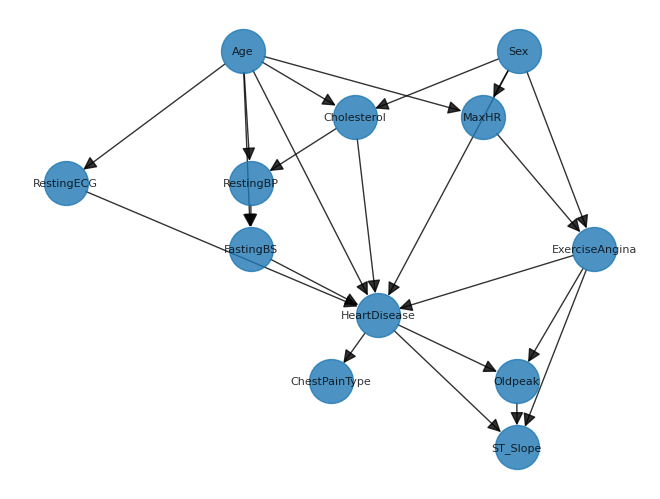

In [26]:
pos = nx.nx_agraph.graphviz_layout(final_model, prog="dot")
nx.draw(final_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

In [27]:
final_model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
final_model.get_cpds()
assert final_model.check_model()

In [ ]:
if not os.path.isdir('model'):
    os.mkdir('model')
final_model.save(f'model{os.sep}heart_disease_model.bif')
writer = XMLBIFWriter(final_model)
writer.write_xmlbif(f'model{os.sep}heart_disease_model.xml')

In [28]:
y_pred = final_model.predict(X_test)
y_pred.head()

  0%|          | 0/147 [00:00<?, ?it/s]

,HeartDisease
0,False
1,False
2,False
3,False
4,True


In [29]:
fbeta_score(y_test, y_pred[target_variable], beta=2)

0.8690176322418136

In [30]:
accuracy_score(y_test, y_pred[target_variable])

0.8533333333333334

### References

<a id="1">[1]</a>
World Health Organization. (2024). Cardiovascular diseases (CVDs). <https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)>

<a id="2">[2]</a>
Mahmood, S. S., Levy, D., Vasan, R. S., & Wang, T. J. (2014). The Framingham Heart Study and the epidemiology of cardiovascular disease: a historical perspective. Lancet (London, England), 383(9921), 999–1008. <https://doi.org/10.1016/S0140-6736(13)61752-3>

<a id="3">[3]</a>
WHO CVD Risk Chart Working Group (2019). World Health Organization cardiovascular disease risk charts: revised models to estimate risk in 21 global regions. The Lancet. Global health, 7(10), e1332–e1345. <https://doi.org/10.1016/S2214-109X(19)30318-3>

<a id="4">[4]</a>
Ordovas, J.; Rios-Insua, D.; Santos-Lozano, A.; Lucia, A.; Torres, A.; Kosgodagan, A.; and Camacho, J. (2023). A bayesian network model for predicting cardiovascular risk. Computer Methods and Programs in Biomedicine. <https://doi.org/10.1016/j.cmpb.2023.107405>